In [21]:
import sys
sys.path.append("../")

In [22]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch

from inverse_warp import inverse_warp

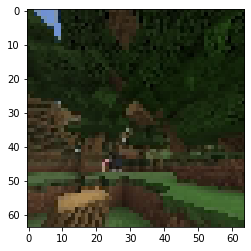

In [23]:
img_orig = imageio.imread("../mc/101.png")
img_orig = img_orig[:, :, :3]

plt.imshow(img_orig)
plt.show()
img = np.transpose(img_orig, (2, 0, 1))
img = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)

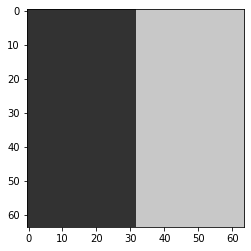

In [24]:
depth_split = np.ones((64, 64, 1), dtype=np.uint8)
depth_split[:, 0:32] = 50
depth_split[:, 32:] = 200

plt.imshow(depth_split, cmap="gray", vmin=0, vmax=255)
plt.show()

depth_split = np.transpose(depth_split, (2, 0, 1))
depth_split = torch.from_numpy(depth_split.astype(np.float32))

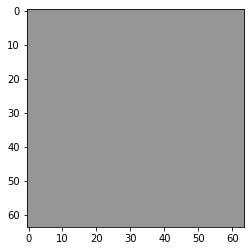

In [25]:
depth_plane = np.full((64, 64, 1), 150, dtype=np.uint8)

plt.imshow(depth_plane, cmap="gray", vmin=0, vmax=255)
plt.show()

depth_plane = np.transpose(depth_plane, (2, 0, 1))
depth_plane = torch.from_numpy(depth_plane.astype(np.float32))

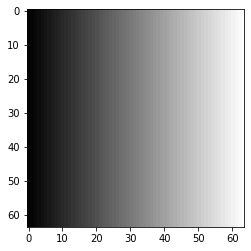

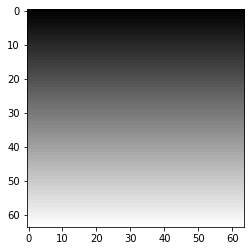

In [26]:
x = np.linspace(0, 255, 64, dtype=np.uint8)
y = np.linspace(0, 255, 64, dtype=np.uint8)
xv, yv = np.meshgrid(x, y)

plt.imshow(xv, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(yv, cmap="gray", vmin=0, vmax=255)
plt.show()

xv = np.expand_dims(xv, axis=-1)
yv = np.expand_dims(yv, axis=-1)

xv = np.transpose(xv, (2, 0, 1))
depth_grad_horiz = torch.from_numpy(xv.astype(np.float32))
yv = np.transpose(yv, (2, 0, 1))
depth_grad_vert = torch.from_numpy(yv.astype(np.float32))

In [27]:
focal_length = 2

intrinsics = np.array([[focal_length, 0, 0],
                       [0, focal_length, 0],
                       [0, 0, 1]])
intrinsics = torch.from_numpy(intrinsics.astype(np.float32)).unsqueeze(0)

In [115]:
pose = np.array([0, 0, 0, 0, 0, 0])
pose = torch.from_numpy(pose.astype(np.float32)).unsqueeze(0)

In [116]:
projected_img, valid_points = inverse_warp(img, depth_split, pose, intrinsics)

In [117]:
projected_img = projected_img.squeeze(0)
projected_img = np.transpose(projected_img, (1, 2, 0))

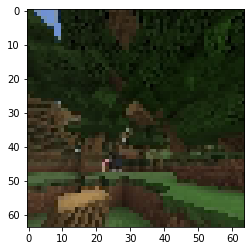

In [118]:
plt.imshow(projected_img.numpy().astype(np.uint8))
plt.show()

6d pose = tx, ty, tz, yaw, pitch, roll

# Photometric loss:

- mean of the absolute difference between original image and warped image
- only valid points from the warped image are used

In [32]:
def photometric_loss(img, depth_img, pose, intrinsics):
    warped_img, valid_points = inverse_warp(img, depth_img, pose, intrinsics)
    
    diff = (img - warped_img) * valid_points.unsqueeze(1).float()
    return diff.abs().mean(), diff, warped_img, valid_points

## Interactive

In [ ]:
from ipywidgets import interactive, Output, FloatSlider
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

output = Output()


@output.capture(clear_output=True)
def f(tx, ty, tz, yaw, pitch, roll, depth):
    pose = np.array([tx, ty, tz, yaw, pitch, roll])
    pose = torch.from_numpy(pose.astype(np.float32)).unsqueeze(0)

    if depth == 0:
        depth_img = depth_split
    elif depth == 1:
        depth_img = depth_grad_horiz
    elif depth == 2:
        depth_img = depth_grad_vert
    elif depth == 3:
        depth_img = depth_plane
        
    reconstruction_loss, _, warped_img, valid_points = photometric_loss(img, depth_img, pose, intrinsics)
    
    print("reconstruction loss: {:.8f}".format(float(reconstruction_loss)))
    
    warped_img = warped_img.squeeze(0)
    warped_img = np.transpose(warped_img, (1, 2, 0))

    plt.figure(figsize=(15, 15), dpi=80)

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig)

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(depth_img, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)

    plt.subplot(1, 3, 3)

    plt.imshow(warped_img.numpy().astype(np.uint8))
    plt.show()

    
interactive_plot = interactive(f,
                               tx=(-1000, 1000, 10),
                               ty=(-1000, 1000, 10),
                               tz=(-1000, 1000, 10),
                               yaw=FloatSlider(min=-0.1, max=0.1, step=0.00001, readout_format=".4"),
                               pitch=FloatSlider(min=-0.1, max=0.1, step=0.00001, readout_format=".4"),
                               roll=FloatSlider(min=-0.1, max=0.1, step=0.00001, readout_format=".4"),
                               depth=[("split", 0),
                                      ("grad horizontal", 1),
                                      ("grad vertical", 2),
                                      ("plane", 3)])

display(interactive_plot)
display(output)

## Limit visualisation

In [8]:
def generate_poses(tx=(-500,500,50), ty=(-500,500,50), tz=(-500,500,50), yaw=(-1,1,0.1), pitch=(-1,1,0.1), roll=(-1,1,0.1)):
    tx = np.linspace(tx[0], tx[1], int((tx[1] - tx[0]) / tx[2] + 1))
    ty = np.linspace(ty[0], ty[1], int((ty[1] - ty[0]) / ty[2] + 1))
    tz = np.linspace(tz[0], tz[1], int((tz[1] - tz[0]) / tz[2] + 1))
    yaw = np.linspace(yaw[0], yaw[1], int((yaw[1] - yaw[0]) / yaw[2] + 1))
    pitch = np.linspace(pitch[0], pitch[1], int((pitch[1] - pitch[0]) / pitch[2] + 1))
    roll = np.linspace(roll[0], roll[1], int((roll[1] - roll[0]) / roll[2] + 1))
    
    return np.array(np.meshgrid(tx, ty, tz, yaw, pitch, roll)).T.reshape(-1,6)


def generate_rotations(yaw=(-1,1,0.1), pitch=(-1,1,0.1), roll=(-1,1,0.1)):
    yaw = np.linspace(yaw[0], yaw[1], int((yaw[1] - yaw[0]) / yaw[2] + 1))
    pitch = np.linspace(pitch[0], pitch[1], int((pitch[1] - pitch[0]) / pitch[2] + 1))
    roll = np.linspace(roll[0], roll[1], int((roll[1] - roll[0]) / roll[2] + 1))
    
    return np.array(np.meshgrid(yaw, pitch, roll)).T.reshape(-1,3)


def generate_translations(tx=(-500,500,10), ty=(-500,500,10), tz=(-500,500,10)):
    tx = np.linspace(tx[0], tx[1], int((tx[1] - tx[0]) / tx[2] + 1))
    ty = np.linspace(ty[0], ty[1], int((ty[1] - ty[0]) / ty[2] + 1))
    tz = np.linspace(tz[0], tz[1], int((tz[1] - tz[0]) / tz[2] + 1))
    
    return np.array(np.meshgrid(tx, ty, tz)).T.reshape(-1,3)

In [178]:
def plot_one_dim_pos(dim, start, stop, step, img, depth_img, intrinsics):
    assert dim is not None

    p = np.linspace(start, stop, int((stop - start) / step + 1))

    photometric_losses = [float(photometric_loss(img, depth_img, torch.from_numpy(np.insert([0, 0, 0, 0, 0], dim, p).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for p in p]
    
    if dim == 0:
        dimension_label = "x"
    elif dim == 1:
        dimension_label = "y"
    elif dim == 2:
        dimension_label = "z"
    elif dim == 3:
        dimension_label = "yaw"
    elif dim == 4:
        dimension_label = "pitch"
    elif dim == 5:
        dimension_label = "roll"
    
    plt.title(f"{dimension_label} translation photometric loss") 
    plt.xlabel(f"{dimension_label} translation") 
    plt.ylabel("photometric loss") 
    plt.plot(p, photometric_losses) 
    plt.show()

### Split depth

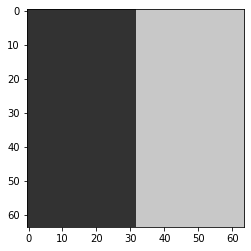

In [155]:
plt.imshow(np.transpose(depth_split, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

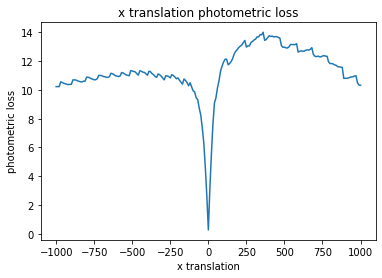

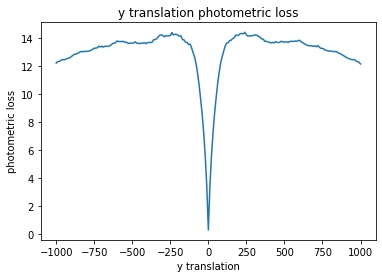

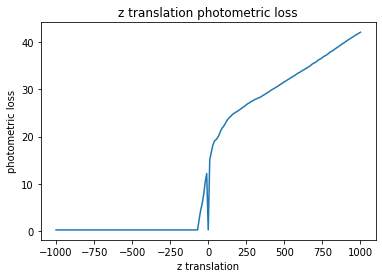

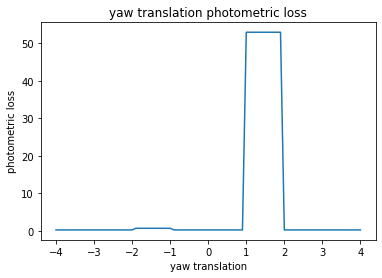

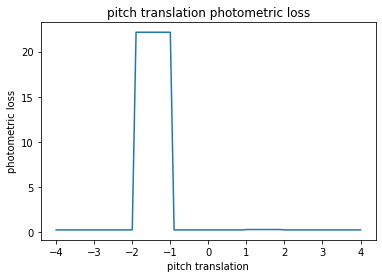

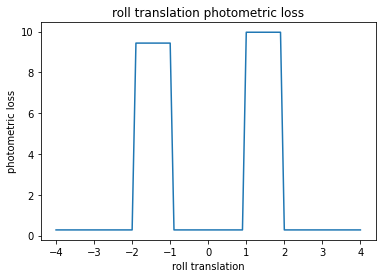

In [199]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)

#### multidimensional

In [65]:
import plotly.graph_objects as go
import numpy as np

translations = generate_translations(tx=(-100,100,10), ty=(-100,100,10), tz=(-100,100,10))

photometric_losses = [float(photometric_loss(img, depth_split, torch.from_numpy(np.concatenate((trans, [0, 0, 0]), axis=0).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for trans in translations]

In [66]:
photometric_losses_sorted = np.argsort(photometric_losses)

In [67]:
photometric_losses_sorted[:100]

array([219, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288,
       287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 300, 301,
       302, 303, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317,
       276, 316, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304,
       315, 328, 275, 273, 244, 243, 242, 241, 240, 239, 238, 237, 236,
       235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223,
       222, 245, 246, 247, 248, 272, 271, 270, 269, 268, 267, 266, 265,
       264, 263, 262, 274, 261, 259, 258, 257, 256])

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=translations[:,0], y=translations[:,2], z=photometric_losses[:], mode="markers")])
fig.update_traces(marker={"size": 3})
fig.show()

### Horizontal gradiend depth

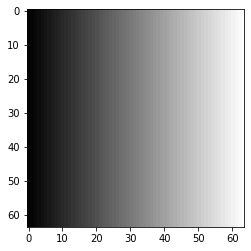

In [156]:
plt.imshow(np.transpose(depth_grad_horiz, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

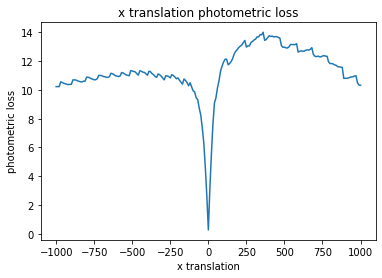

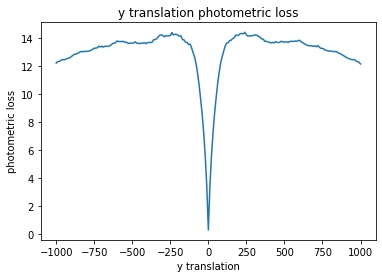

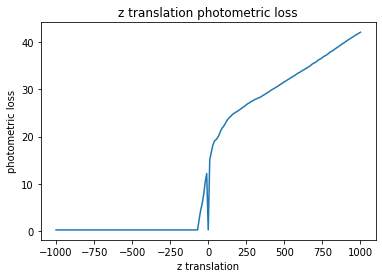

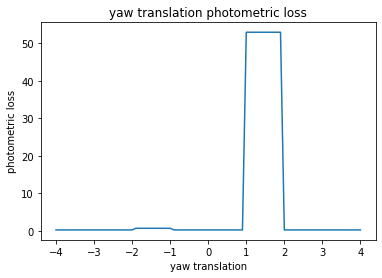

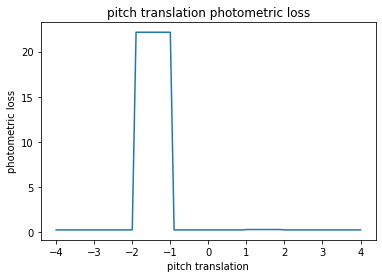

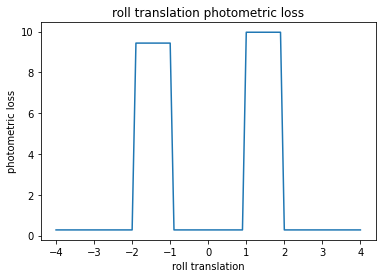

In [198]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)

### Vertical gradiend depth

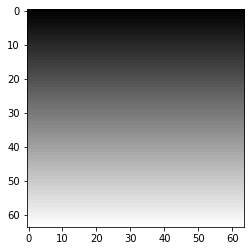

In [157]:
plt.imshow(np.transpose(depth_grad_vert, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

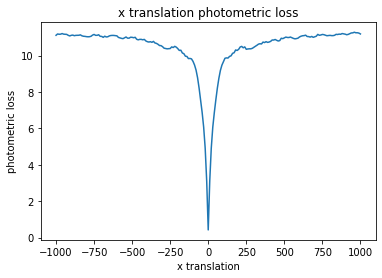

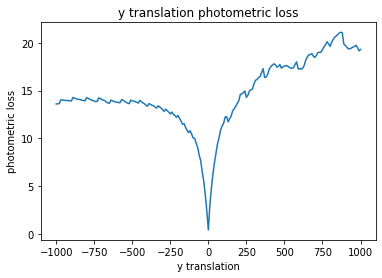

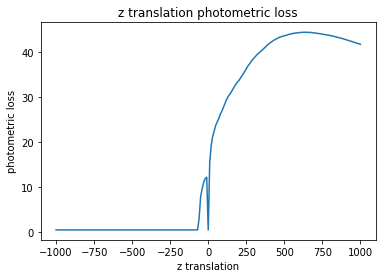

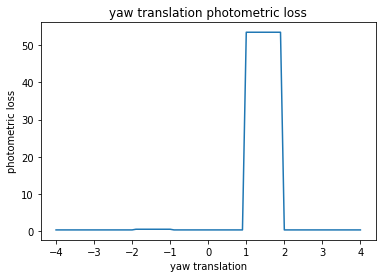

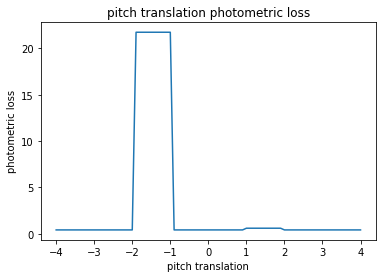

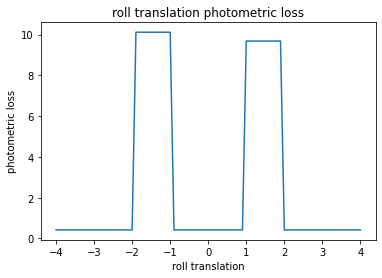

In [197]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)

### Plane depth

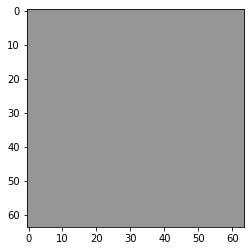

In [191]:
plt.imshow(np.transpose(depth_plane, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

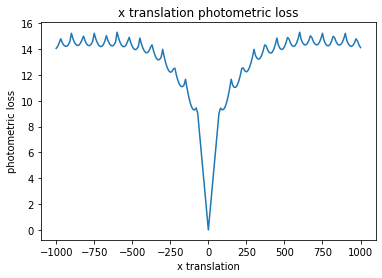

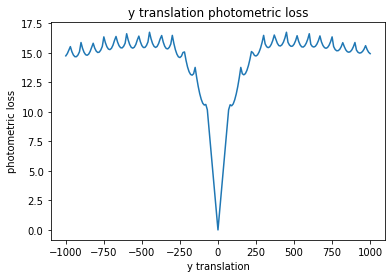

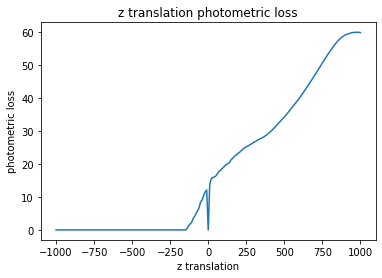

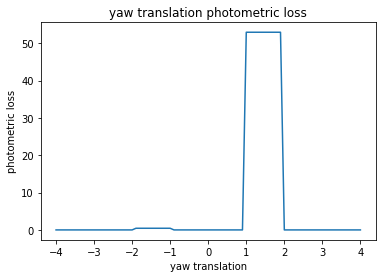

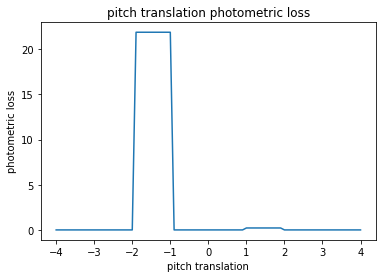

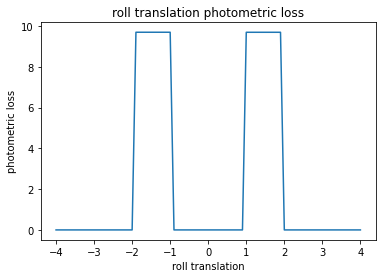

In [196]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_plane, intrinsics=intrinsics)